In [1]:
import numpy as np
import sys, random
import torch
#from torchvision import models, transforms
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import json
import argparse
import pyvision.models as models
import os
# Paths for image directory and model
IMDIR="images"
#MODEL='checkpoints/025x-FDMobileNet-224.pth.tar'

# Load the model for testing
#model = torch.load(MODEL)


json_file=open("custom/customLytica.json")
model_config_dir=open("custom/0.25x-FDMobileNet-224.json")
checkpoint_dir="resultado/lytica025.pth"

data_config = json.load(json_file)
model_config = json.load(model_config_dir)
print('==> Creating model `{}`...'.format(model_config['name']))


==> Creating model `fast_downsampling_mobilenet`...


In [2]:

model = models.get_model(data_config['name'], model_config)
checkpoint = torch.load(checkpoint_dir)
#print('==> Checkpoint name is `{}`.'.format(checkpoint['name']))

/mnt/b544e4c4-877a-4cd8-a91d-85c44fafd63a/ANACONDA/LYTICA/VICO_Classifier/mobileNetFD/FD-MobileNet/pyvision/models/ImageNet/MobileNet.py:47: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(module.weight, 1)
/mnt/b544e4c4-877a-4cd8-a91d-85c44fafd63a/ANACONDA/LYTICA/VICO_Classifier/mobileNetFD/FD-MobileNet/pyvision/models/ImageNet/MobileNet.py:48: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(module.bias, 0)
/mnt/b544e4c4-877a-4cd8-a91d-85c44fafd63a/ANACONDA/LYTICA/VICO_Classifier/mobileNetFD/FD-MobileNet/pyvision/models/ImageNet/MobileNet.py:43: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(module.weight, mode='fan_in')
/mnt/b544e4c4-877a-4cd8-a91d-85c44fafd63a/ANACONDA/LYTICA/VICO_Classifier/mobileNetFD/FD-MobileNet/pyvision/models/ImageNet/MobileNet.py:45: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.

In [3]:
model

MobileNet(
  (features): Sequential(
    (conv_0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm_0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu_0): ReLU(inplace=True)
    (dw_conv_0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=8, bias=False)
    (dw_norm_0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dw_relu_0): ReLU(inplace=True)
    (pw_conv_0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (pw_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pw_relu_0): ReLU(inplace=True)
    (dw_conv_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
    (dw_norm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dw_relu_1): ReLU(inplace=True)
    (pw_conv_1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1,

In [4]:
model.load_state_dict(checkpoint['state_dict'])
model = torch.nn.DataParallel(model).cuda()
print('==> Creating model completed.')
    


==> Creating model completed.


In [5]:

model.eval()

print(model)

DataParallel(
  (module): MobileNet(
    (features): Sequential(
      (conv_0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm_0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_0): ReLU(inplace=True)
      (dw_conv_0): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=8, bias=False)
      (dw_norm_0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dw_relu_0): ReLU(inplace=True)
      (pw_conv_0): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (pw_norm_0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pw_relu_0): ReLU(inplace=True)
      (dw_conv_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
      (dw_norm_1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dw_relu_1): ReLU(inplace=True)
      (pw_

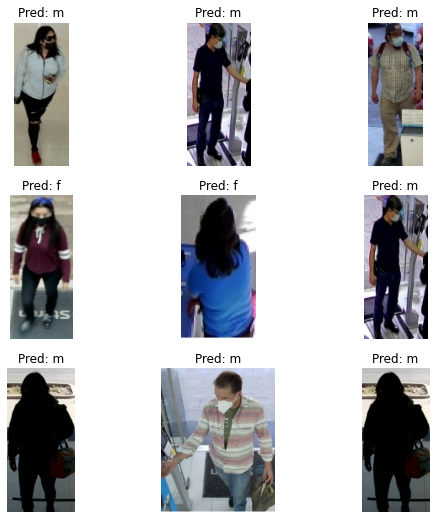

'\nSample run: python test.py test\n'

In [7]:

from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
#model to device
##### HELPER FUNCTION FOR FEATURE EXTRACTION
features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook


#model.embedding_block.register_forward_hook(get_features('feats'))

# Class labels for prediction
#class_names = ['client','employee'] #['0-15','16-24','25-34','35-44','45-54','55-64','65-100']   #f,m
class_names = ['f','m']
#class_names = ['0-15','16-24','25-34','35-44','45-54','55-64','65-100']

# Retreive 9 random images from directory
files=Path(IMDIR).resolve().glob('*.*')
files_l = list(files)
images=random.sample(files_l, 9)

# Configure plots
fig = plt.figure(figsize=(9,9))
rows,cols = 3,3

# Preprocessing transformations
preprocess=transforms.Compose([
        #transforms.Resize(size=(224, 128)),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

# Enable gpu mode, if cuda available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Perform prediction and plot results
with torch.no_grad():
    for num,img in enumerate(images):
         img=Image.open(img).convert('RGB')
         inputs=preprocess(img).unsqueeze(0).to(device)
         outputs = model(inputs)
         #print(features['feats'].cpu().numpy())
         #print(outputs.shape)
         _, preds = torch.max(outputs, 1)    
         label=class_names[preds]
         plt.subplot(rows,cols,num+1)
         plt.title("Pred: "+label)
         plt.axis('off')
         plt.imshow(img)
    plt.show()
'''
Sample run: python test.py test
'''
